In [1]:
import pandas as pd
import numpy as np
import pickle
import glob
import scipy.stats as st
from scipy.special import softmax
import datetime
from tslearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, confusion_matrix

In [2]:
LIM_fac = ["AMP"]
ESAM_fac = ["OPTMON", "OSC"]
OSC_fac = ["OPTMON, OSC"]
WSSOPM_fac = ["OPTMON"]
prime_pms = ["OCH-OPR","OPR-OTS","OPIN-OTS","OPROSC-OTS","OCH-OPT","OPT-OTS","OPOUT-OTS"]
variance_threshold = 0.05
seq_length_threshold = 60
# nh_files = glob.glob('results_anonymised_updated//df_nhresult_vodafone_01-02_2020//part*.csv')
topo_files = glob.glob('results_anonymised_Oct_30//df_topo_*.csv')
nh_parent_files = glob.glob('results_anonymised_Oct_30//df_nhresult_vodafone*')

In [3]:
# get connection information of the network from topo data
# -----------------------------------------------------

path_dictionary = {}
path = 1

for topo_file in topo_files:
    topo_data = pd.read_csv(topo_file)
    for index, row in topo_data.iterrows():

        current_tid = row['tid_scrambled']
        _, current_shelf, current_slot = row['lim'].split('-')
        current_tid = current_tid + "_" + current_shelf + "_" + current_slot
        current_n1 = row['neighbor1_scrambled']
        _, n1_shelf, n1_slot = row['neighbor1-lim'].split('-')
        current_n1 = current_n1 + "_" + n1_shelf + "_" + n1_slot
        if path == 1:
            key_name = "path_" + str(path)
            path_dictionary[key_name] = []
            path_dictionary[key_name].append(current_tid)
            path_dictionary[key_name].append(current_n1)
            path+=1
            continue
        flag = 0
        for p in path_dictionary.keys():
            if (current_tid in path_dictionary[p]) and (current_n1 in path_dictionary[p]):
                flag = 1
                continue
            if current_tid in path_dictionary[p]:
                if current_n1 not in path_dictionary[p]:
                    path_dictionary[p].append(current_n1)
                    flag = 1
                    continue
            if current_n1 in path_dictionary[p]:
                if current_tid not in path_dictionary[p]:
                    path_dictionary[p].append(current_tid)
                    flag = 1
                    continue
        if flag == 0:
            key_name = "path_" + str(path)
            path_dictionary[key_name] = []
            path_dictionary[key_name].append(current_tid)
            path_dictionary[key_name].append(current_n1)
            path += 1

In [106]:
# show initial cluster information
# -----------------------------------------------------
keys = path_dictionary.keys()
values = path_dictionary.values()
columns = ['TID_1', 'TID_2', 'TID_3', 'TID_4', 'TID_5']
cluster_information = pd.DataFrame(values, keys, columns=columns)
print("Number of cluster: %d" %(cluster_information.shape[0]))
print(cluster_information[0:50])

number of cluster: 357


In [108]:
# save to csv file
# -----------------------------------------------------

cluster_information.to_csv('path_information.csv')

In [4]:
# extract time series from raw data set
# -----------------------------------------------------

time_series_data = {}
for nh_parent_file in nh_parent_files:
    print(nh_parent_file)
    nh_files = glob.glob(nh_parent_file+'//part*.csv')
    for nh_file in nh_files:
        data = pd.read_csv(nh_file)

        for index, row in data.iterrows():
            if row['pm'] not in prime_pms:
                 continue
#             current_group = row['pec']+"_"+row['port_key_anonymised']+"_"+row['pm']
            current_group = row['mename_anonymised'] + "_" + str(row['shelf']) + "_" + str(row['slot']) + "_" + str(row['port']) +"_" + str(row['pm'])
            if current_group not in time_series_data.keys():
                time_series_data[current_group] = []
            compare_string = row['mename_anonymised'] + "_" + str(row['shelf']) + "_" + str(row['slot'])
            time_series_data[current_group].append({ "comp": compare_string, "shelf": row['shelf'],  
                                                    "slot": row['slot'], "port": row['port'], "pm": row['pm'],
                                                   "ts": row['pmtime'], "pmvalue": row['pmvalue']})

results_anonymised_Oct_30\df_nhresult_vodafone_01-02_2020.csv.csv
results_anonymised_Oct_30\df_nhresult_vodafone_01-03_2020.csv.csv
results_anonymised_Oct_30\df_nhresult_vodafone_14-02_2020.csv.csv
results_anonymised_Oct_30\df_nhresult_vodafone_15-03_2020.csv.csv
results_anonymised_Oct_30\df_nhresult_vodafone_29-02_2020.csv.csv
results_anonymised_Oct_30\df_nhresult_vodafone_30-03_2020.csv.csv


In [6]:
# save and load file
# -----------------------------------------------------
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
save_obj(time_series_data, 'time_series_data')

# show a time series
# -----------------------------------------------------

a = time_series_data.keys()
key = list(a)[0]
b = pd.DataFrame(time_series_data[key])
print(b)
len(a)

                comp  shelf  slot  port       pm          ts  pmvalue
0   034-3435f-72_2_7      2     7     2  OCH-OPT  1579227300     -1.5
1   034-3435f-72_2_7      2     7     2  OCH-OPT  1579313700     -1.5
2   034-3435f-72_2_7      2     7     2  OCH-OPT  1579400100     -1.5
3   034-3435f-72_2_7      2     7     2  OCH-OPT  1579486500     -1.5
4   034-3435f-72_2_7      2     7     2  OCH-OPT  1579572900     -1.5
..               ...    ...   ...   ...      ...         ...      ...
61  034-3435f-72_2_7      2     7     2  OCH-OPT  1585016100     -1.5
62  034-3435f-72_2_7      2     7     2  OCH-OPT  1585102500     -1.5
63  034-3435f-72_2_7      2     7     2  OCH-OPT  1585361700     -1.5
64  034-3435f-72_2_7      2     7     2  OCH-OPT  1585448100     -1.5
65  034-3435f-72_2_7      2     7     2  OCH-OPT  1585534500     -1.5

[66 rows x 7 columns]


49387

In [112]:
# length of extracted time series
# -----------------------------------------------------

series_length = ([pd.DataFrame(time_series_data[key])['pmvalue'].count() for key in time_series_data.keys()])

print(series_length)

[66, 66, 66, 66, 66, 68, 65, 64, 66, 66, 69, 68, 61, 66, 65, 66, 66, 81, 68, 79, 66, 66, 66, 66, 68, 53, 66, 79, 77, 78, 79, 79, 77, 79, 80, 80, 73, 82, 82, 67, 78, 82, 73, 85, 81, 83, 67, 69, 77, 79, 84, 78, 70, 70, 63, 66, 84, 55, 70, 68, 70, 67, 69, 69, 72, 68, 69, 69, 79, 79, 66, 79, 80, 79, 79, 79, 79, 79, 79, 79, 79, 82, 82, 79, 81, 79, 79, 81, 79, 80, 81, 79, 77, 81, 80, 68, 80, 82, 70, 79, 70, 76, 81, 83, 66, 68, 53, 61, 66, 66, 66, 66, 66, 66, 68, 66, 66, 66, 66, 67, 67, 66, 64, 66, 39, 39, 66, 66, 64, 64, 68, 66, 66, 53, 53, 66, 66, 64, 78, 78, 79, 79, 66, 66, 79, 69, 69, 79, 72, 79, 71, 81, 55, 64, 79, 68, 81, 63, 74, 79, 79, 79, 79, 45, 66, 71, 69, 65, 79, 75, 66, 67, 66, 69, 66, 79, 61, 81, 68, 61, 78, 80, 80, 66, 58, 80, 66, 67, 66, 66, 80, 80, 66, 66, 66, 66, 68, 66, 69, 66, 71, 50, 69, 69, 66, 66, 66, 69, 66, 66, 66, 66, 66, 66, 66, 64, 66, 66, 59, 66, 79, 66, 68, 79, 66, 81, 81, 79, 68, 80, 82, 79, 78, 79, 79, 79, 79, 77, 81, 80, 72, 70, 80, 81, 82, 79, 70, 79, 82, 81,

In [7]:
# filter time series that satisfy variance threshold and seq_length_threshold
# -----------------------------------------------------

time_series_essential = []
min_length = []
for path in path_dictionary.keys():
    for node in path_dictionary[path]:
        for key in time_series_data.keys():
            if time_series_data[key][0]['comp'] == node:
                x = pd.DataFrame(time_series_data[key])
                if (np.var(x['pmvalue']) > variance_threshold) & (x['pmvalue'].__len__() > seq_length_threshold):
                    min_length.append(x['ts'].count())
                    x = x.sort_values('ts')
                    time_series_essential.append({ "path": path, "node": node, "shelf": x['shelf'][0], "slot": x['slot'][0], 
                                                  "port": x['port'][0], "pm": x['pm'][0], "timestamp": pd.to_datetime(x['ts'], unit='s').dt.date, 
                                                  "data": np.asarray(x['pmvalue'])})

In [118]:
# show a time series
# -----------------------------------------------------

print("Number of satisfied time series: %d" %len(time_series_essential))
pd.DataFrame(time_series_essential)

Number of satisfied time series: 1815


,path,node,shelf,slot,port,pm,timestamp,data
0,path_3,208-24781-95_1_2,1,2,8,OPOUT-OTS,30 2019-06-19 31 2019-06-20 32 2019-0...,"[14.300000190734865, 14.300000190734865, 14.30..."
1,path_5,f9e-c2fb2-00_1_2,1,2,8,OPIN-OTS,33 2019-06-19 34 2019-06-20 35 2019-0...,"[-4.900000095367432, -4.900000095367432, -4.90..."
2,path_5,f9e-c2fb2-00_1_2,1,2,6,OPIN-OTS,32 2019-06-19 33 2019-06-20 34 2019-0...,"[-1.2000000476837158, -1.2000000476837158, -1...."
3,path_5,f9e-c2fb2-00_1_2,1,2,6,OPOUT-OTS,33 2019-06-19 34 2019-06-20 35 2019-0...,"[8.300000190734862, 8.300000190734862, 8.30000..."
4,path_5,f9e-c2fb2-00_1_2,1,2,8,OPOUT-OTS,30 2019-06-19 42 2019-06-20 31 2019-0...,"[8.5, 8.399999618530272, 8.399999618530272, 8...."
...,...,...,...,...,...,...,...,...
1810,path_353,397-dabdc-35_2_2,2,2,8,OPIN-OTS,29 2019-06-19 30 2019-06-20 31 2019-0...,"[-2.5999999046325684, -2.5999999046325684, -2...."
1811,path_353,50d-895d1-ab_2_2,2,2,8,OPIN-OTS,34 2019-06-19 35 2019-06-20 40 2019-0...,"[-0.4000000059604645, -0.4000000059604645, -1...."
1812,path_353,50d-895d1-ab_2_2,2,2,6,OPIN-OTS,30 2019-06-19 38 2019-06-20 31 2019-0...,"[-3.7000000476837163, -3.7999999523162837, -3...."
1813,path_353,50d-895d1-ab_2_2,2,2,8,OPOUT-OTS,34 2019-06-19 31 2019-06-20 33 2019-0...,"[11.699999809265135, 11.800000190734865, 11.10..."


In [8]:
# get the time stamps of time series
# -----------------------------------------------------

tsd = pd.DataFrame(time_series_essential)
date_bucket = []
for i in range(0,tsd.__len__()):
    date_bucket = np.hstack((date_bucket, np.asarray(tsd['timestamp'][i])))
date_bucket = np.unique(date_bucket)
date_bucket = date_bucket[date_bucket > datetime.date(2020, 1, 1)]

In [9]:
# time series after being interpolated
# -----------------------------------------------------

interpolated_time_series = []
for i in range(0,tsd.__len__()):
    series = pd.DataFrame(tsd['data'][i], tsd['timestamp'][i])
    series = series[~series.index.duplicated(keep='first')]
    series = series[series.index > datetime.date(2020, 1, 1)]
#     series = series.reindex(date_bucket, fill_value=0).sort_index().mask(series == 0).interpolate()
    series = series.reindex(date_bucket).sort_index().interpolate()
    if series.isna().sum()[0] > series.__len__() / 2 or series.var()[0] < variance_threshold:
        continue
    elif series.isna().sum()[0] > 0:
        series = series.fillna(0)
#         print("Number %d" %i)
    series['zscore'] = st.zscore(series)
    interpolated_time_series.append(
        {"path": tsd['path'][i], "node": tsd['node'][i], "shelf": tsd['shelf'][i], "slot": tsd['slot'][i],
         "port": tsd['port'][i], "pm": tsd['pm'][i], "timestamp": np.asarray(series.index), 
         "raw_data": np.asarray(series[0]),"z-score": np.asarray(series['zscore'])})


In [205]:
# the final data set of time series
# -----------------------------------------------------

print("Number of time series: %d" %(interpolated_time_series.__len__()))
print("Length of each time series: %d" %(interpolated_time_series[0]['raw_data'].shape[0]))
pd.DataFrame(interpolated_time_series)

Number of time series: 1259
Length of each time series: 55


,path,node,shelf,slot,port,pm,timestamp,raw_data,z-score
0,path_3,208-24781-95_1_2,1,2,8,OPOUT-OTS,"[2020-01-17, 2020-01-18, 2020-01-19, 2020-01-2...","[14.300000190734865, 14.300000190734865, 14.30...","[-1.606452585907533, -1.606452585907533, -1.60..."
1,path_5,f9e-c2fb2-00_1_2,1,2,8,OPIN-OTS,"[2020-01-17, 2020-01-18, 2020-01-19, 2020-01-2...","[-4.699999809265137, -4.800000190734863, -4.80...","[-0.11154559786071622, -0.3160475996011312, -0..."
2,path_5,f9e-c2fb2-00_1_2,1,2,6,OPIN-OTS,"[2020-01-17, 2020-01-18, 2020-01-19, 2020-01-2...","[-0.699999988079071, -0.699999988079071, -0.69...","[-0.38573315088081656, -0.38573315088081656, -..."
3,path_5,f9e-c2fb2-00_1_2,1,2,6,OPOUT-OTS,"[2020-01-17, 2020-01-18, 2020-01-19, 2020-01-2...","[8.800000190734863, 8.899999618530273, 8.89999...","[-0.4175761901623922, -0.0847274439814516, -0...."
4,path_5,f9e-c2fb2-00_1_2,1,2,8,OPOUT-OTS,"[2020-01-17, 2020-01-18, 2020-01-19, 2020-01-2...","[8.600000381469728, 8.600000381469728, 8.60000...","[-0.14596176152485704, -0.14596176152485704, -..."
...,...,...,...,...,...,...,...,...,...
1254,path_349,8e0-c276b-a0_1_2,1,2,8,OPIN-OTS,"[2020-01-17, 2020-01-18, 2020-01-19, 2020-01-2...","[-14.199999809265135, -14.199999809265135, -14...","[0.6536578272515414, 0.6536578272515414, 0.601..."
1255,path_349,8e0-c276b-a0_1_2,1,2,8,OPOUT-OTS,"[2020-01-17, 2020-01-18, 2020-01-19, 2020-01-2...","[6.0, 6.0, 5.9000000953674325, 5.8000001907348...","[0.6341642249914571, 0.6341642249914571, 0.575..."
1256,path_353,397-dabdc-35_2_2,2,2,8,OPOUT-OTS,"[2020-01-17, 2020-01-18, 2020-01-19, 2020-01-2...","[13.699999809265135, 13.800000190734865, 13.60...","[1.2436788922150985, 1.6484283335756091, 0.838..."
1257,path_353,50d-895d1-ab_2_2,2,2,6,OPIN-OTS,"[2020-01-17, 2020-01-18, 2020-01-19, 2020-01-2...","[-5.0, -4.900000095367432, -5.099999904632568,...","[0.17599307576413806, 0.4011004108836728, -0.0..."


In [16]:
# import csv
# field_names = ['path', 'node', 'shelf', 'slot', 'port', 'pm', 'raw_data', 'z-score', 'timestamp']
# with open('interpolated_time_series.csv', 'w') as f:
#     writer = csv.DictWriter(f, fieldnames=field_names)
#     # for row in interpolated_time_series:
#     writer.writeheader()
#     writer.writerows(interpolated_time_series)

In [1]:
# create the matrix of time series
# -----------------------------------------------------

time_series_df = pd.DataFrame(interpolated_time_series)['z-score']
time_series_list = time_series_df.to_list()
time_series = []
for row in time_series_list:
    time_series.append(row)

time_series_array = np.array(time_series)

NameError: name 'pd' is not defined

In [299]:
# save the final data set to file
# -----------------------------------------------------

attributes = ['path', 'node', 'port', 'pm']
index_df = pd.DataFrame(interpolated_time_series)[attributes]
# print(index)
ts_df = pd.DataFrame(time_series_array)
frames = [index_df, ts_df]
time_series_clustered = pd.concat(frames, axis=1)
# print(time_series_clustered)
time_series_clustered.to_csv('time_series_clustered.csv')

In [59]:
# VALIDATION 
# -----------------------------------------------------
n = time_series_array.shape[0]
# n = 100

# create the target matrix
# -----------------------------------------------------

group_number = pd.DataFrame(interpolated_time_series)['path']
target_matrix = np.zeros(shape=(n, n))
for i in range(n):
    for j in range(n):
        if group_number[i] == group_number[j]:
            target = 1
        else:
            target = 0
        target_matrix[i, j] = target

# print(target_matrix)

# create the prediction matrix
# -----------------------------------------------------

similarity_matrix = np.zeros(shape=(n, n))
for i in range(n):
    for j in range(n):
        similarity = (np.power(metrics.dtw(time_series_array[i], np.zeros(time_series_array[i].size)), 2) + 
                   np.power(metrics.dtw(time_series_array[j], np.zeros(time_series_array[j].size)), 2) -
                   np.power(metrics.dtw(time_series_array[i], time_series_array[j]), 2))/2
#         similarity = 1/(1 + metrics.dtw(time_series_array[i], time_series_array[j]))
        similarity_matrix[i, j] = similarity

similarity_matrix_normalized = softmax(similarity_matrix, axis=0)

# print(similarity_matrix)
# print(similarity_matrix[1])
# print(similarity_matrix_normalized[1])


In [69]:
similarity_matrix_normalized.shape

(1259, 1259)

In [61]:
target_flatted = target_matrix.reshape(-1, 1).astype('int32')
prediction_flatted = prediction_matrix.reshape(-1, 1).astype('int32')
prediction_score_flatted = similarity_matrix_normalized.reshape(-1, 1)

In [62]:
precision = precision_score(target_flatted, prediction_flatted)
recall = recall_score(target_flatted, prediction_flatted)
print("precision_score: %.3f" %precision)
print("recall_score: %.3f" %recall)

confusion_matrix(target_flatted, prediction_flatted)

precision_score: 0.965
recall_score: 0.241


array([[1576800,      72],
       [   6232,    1977]], dtype=int64)

In [63]:
precisions, recalls, thresholds = precision_recall_curve(target_flatted, prediction_score_flatted)

In [47]:
max(thresholds)

0.9999982575051309

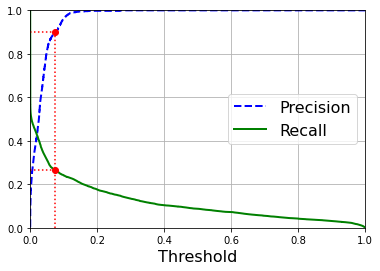

In [64]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([0, 1, 0, 1])             # Not shown
    
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")  
plt.plot([0, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([0, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro");

In [68]:
threshold_90_precision

0.07325357291736374

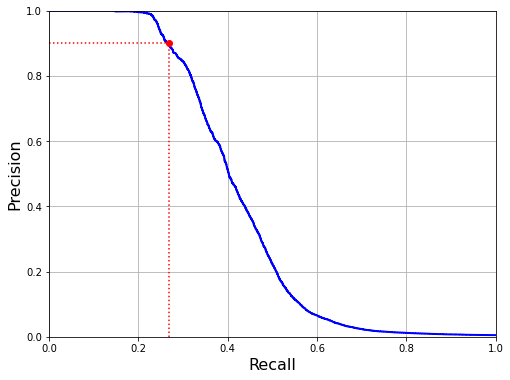

In [66]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
# save_fig("precision_vs_recall_plot")
plt.show()

In [70]:
threshold = 0.07
prediction_matrix = np.where(similarity_matrix_normalized > threshold, 1, 0)
a = target_matrix.reshape(-1, 1).astype('int')
b = prediction_matrix.reshape(-1, 1).astype('int')
TP = 0; FP = 0; FN = 0
for i in range(a.shape[0]):
    if (b[i] == 1) and (a[i] == 1):
        TP = TP + 1
    elif (b[i] == 1) and (a[i] == 0):
        FP = FP + 1
    elif (b[i] == 0) and (a[i] == 1):
        FN = FN + 1
        
print("TP: %d FP: %d FN: %d " %(TP, FP, FN))

TP: 2215 FP: 267 FN: 5994 


In [72]:
precision = TP/(TP + FP)
recall = TP/(TP + FN)
print("Precision: %.3f" %precision)
print("Recall: %.3f" %recall)
confusion_matrix(target_flatted, prediction_flatted)

Precision: 0.892
Recall: 0.270


array([[1576800,      72],
       [   6232,    1977]], dtype=int64)

In [79]:
# VALIDATION 
# -----------------------------------------------------
# n = time_series_array.shape[0]
n = 20

# create the target matrix
# -----------------------------------------------------

group_number = pd.DataFrame(interpolated_time_series)['path']
target_matrix = np.zeros(shape=(n, n))
for i in range(n):
    for j in range(n):
        if group_number[i] == group_number[j]:
            target = 1
        else:
            target = 0
        target_matrix[i, j] = target

# print(target_matrix)

# create the prediction matrix
# -----------------------------------------------------

similarity_matrix = np.zeros(shape=(n, n))
for i in range(n):
    for j in range(n):
#         similarity = (np.power(metrics.dtw(time_series_array[i], np.zeros(time_series_array[i].size)), 2) + 
#                    np.power(metrics.dtw(time_series_array[j], np.zeros(time_series_array[j].size)), 2) -
#                    np.power(metrics.dtw(time_series_array[i], time_series_array[j]), 2))/2
        similarity = 1/(1 + metrics.dtw(time_series_array[i], time_series_array[j]))
        similarity_matrix[i, j] = similarity

    
similarity_matrix_normalized = softmax(similarity_matrix, axis=0)




In [80]:
# print(similarity_matrix)
print(similarity_matrix[1])
print(similarity_matrix_normalized[1])

[0.09552941 1.         0.49952273 0.49057053 0.54799555 0.60193408
 0.63746338 0.49425018 0.41835913 0.24615452 0.24164386 0.24194153
 0.23140453 0.2469847  0.25237973 0.23431936 0.2363893  0.24206345
 0.24200866 0.25289051]
[0.04621575 0.09144627 0.0555237  0.05402948 0.05943206 0.06066116
 0.06275689 0.05418021 0.0526249  0.03896317 0.03945151 0.04065216
 0.04059973 0.03920187 0.03945852 0.04083283 0.04109102 0.03869491
 0.03874829 0.03958403]
